06 - Accessing the Shot HDF5 File
=======

Each HETDEX observation or shot (organized by DATEvOBS) consists of 3 dithered exposures. The shot HDF5 includes calibrated data products (flux-calibrated fiber spectra and associated astrometric information) and intermediary data products (2D processed images). It also contains shot specific astrometric and calibration information. This notebook illustrates how to open a shot HDF5 file and examine its contents. For a user who wants to quickly capture data from the shot file, please go to the 02 - The SHOT API notebook. 


In [3]:
import sys
import os
import os.path
import subprocess
import numpy as np

import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval


Lets begin by exploring the hierarchy of an example shot file.

In [4]:
fileh = tb.open_file('/Users/erin/Desktop/20180124v010.h5')

In [5]:
fileh.root.Shot.cols

/Shot.cols (Cols), 15 columns
  date (Column(1,), int32)
  obsid (Column(1,), int32)
  ra (Column(1,), float32)
  dec (Column(1,), float32)
  objid (Column(1,), |S18)
  pa (Column(1,), float32)
  mjd (Column(1,), float32)
  ambtemp (Column(1,), float32)
  dewpoint (Column(1,), float32)
  expn (Column(1,), int32)
  exptime (Column(1,), float32)
  humidity (Column(1,), float32)
  obsind (Column(1,), int32)
  pressure (Column(1,), float32)
  time (Column(1,), |S7)

In [6]:
fileh.root.Astrometry

/Astrometry (Group) 'Astrometry Info'
  children := ['CoaddImages' (Group), 'PositionOffsets' (Group), 'QA' (Table), 'fplane' (Table), 'Dithall' (Group), 'StarCatalog' (Table)]

In [7]:
Images = fileh.root.Data.Images

As an example, I will search the file for a very bright known LAE that I know is in this shot. If you want to find out what shots an object is in use the XXXXquery_radecXXX (to be written) function.  

DEEP406749 with ra=150.025513, dec=2.087767, wave=3710.77

In [8]:
ra_obj = 150.025513
dec_obj = 2.087767
wave_obj = 3710.77

The fibers table can be linked to a variable (but is not yet pulled into memory)

In [9]:
fibers = fileh.root.Data.Fibers

Use the read_where tables function to access all fibers in the fibers table that are in a 3" aperture of the objects position.

In [10]:
subtable = fibers.read_where("sqrt(((ra - ra_obj)**2 + (dec - dec_obj)**2)) < 3./3600.")

In [11]:
nfibers = np.size(subtable)
nfibers

12

`nfibers` fall within a 3" radius of the detection, let's grab all fibers and plot them together:

In [12]:
def plot_spectrum(self, xlim=None, ylim=None):
    plt.plot(self['wavelength'], self['sky_subtracted'])
    if xlim is not None:
        plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)

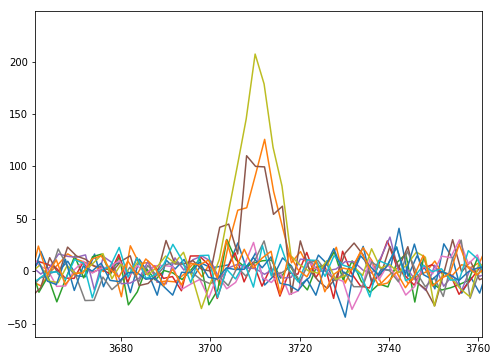

In [13]:
plt.figure(figsize=(8, 6))
ymax = 1.2*np.max(subtable['sky_subtracted'])
ymin = np.min(subtable['sky_subtracted'])
for i in np.arange(nfibers):
    plot_spectrum(subtable[i], xlim=[wave_obj-50,wave_obj+50], ylim=[ymin,ymax])

Access the image at the brightest fiber above. An easy way to approximate the line flux is to sum up along a wavelength interval.

In [14]:
sumspec = list()
for i in np.arange(nfibers):    
    iwave = np.where((subtable[i]['wavelength']> wave_obj-10) & (subtable[i]['wavelength']> wave_obj+10))
    sumspec.append( np.sum(subtable[i]['sky_subtracted']))

Find the brightest fiber and get associated fiber information. This will allow us to find the location of the data in the 2D frame.

In [15]:
i = np.argmax(sumspec)
specid_obj = subtable[i]['specid']
amp_obj = subtable[i]['amp']
fibnum_obj = subtable[i]['fibnum']
expnum_obj = subtable[i]['expnum']
fpx_obj = int(subtable[i]['fpx'])
fpy_obj = int(subtable[i]['fpy'])

In [16]:
im0 = Images.read_where("(specid == specid_obj) & (amp == amp_obj) & (expnum == expnum_obj)")

In [17]:
wave_data = subtable[i]['wavelength']
trace_data = subtable[i]['trace']

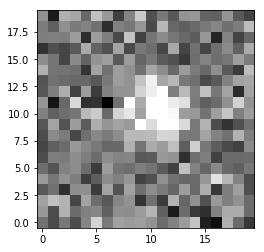

In [18]:
x = int(round(np.interp(wave_obj,wave_data,range(len(wave_data)))))
y = int(round(np.interp(x,range(len(trace_data)),trace_data)))
implot = im0['clean_image'][0][y-10:y+10,x-10:x+10]
zscale = ZScaleInterval(contrast=0.5,krej=2.5) 
vmin, vmax = zscale.get_limits(values=implot)
plt.imshow(implot,vmin=vmin, vmax=vmax, origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")